# Libreria

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL
from PIL import Image
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold

torch.manual_seed(123)
random.seed(123)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [ ]:
#Asegurar que trabajamos en la GPU
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


# Dataset

In [ ]:
# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((78, 78)), #Se asegura todas las imagenes tienen la misma forma con un ajuste de tamaño
    transforms.ToTensor(),  # Convertir a tensor de PyTorch
])



# Crear dataset personalizado de PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = ['Under', 'Over', 'Empty', 'OK']
        self.imgs = []
        
        for i, cls in enumerate(self.classes):
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.imgs.append((img_path, i))  # Añadir ruta de imagen y su label
        
        # Mezclar las imágenes antes de dividir el dataset
        random.shuffle(self.imgs)
                
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        return img, label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Crear el dataset personalizado
dataset = CustomDataset('/content/drive/MyDrive/DatasetTFG/labeled')

In [ ]:
dataset1 = torch.utils.data.Subset(dataset, range(10000)) # Se crea un dataset del tamaño deseado apartir del total

# Definir tamaño de los conjuntos de entrenamiento y validación (80%-20%)
train_size = int(0.8 * len(dataset1))
val_size = len(dataset1) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset1, [train_size, val_size])

dataset_part = ConcatDataset([train_data, val_data])

# Modelo

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.3MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
from sklearn.model_selection import KFold #Se importa KFold de la libreria de modelos de sklearn
k_folds = 5
results = {}
loss_function = nn.CrossEntropyLoss()

def train_model(model, dataset, num_epochs=25, is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    kfold = KFold(n_splits=k_folds, shuffle=True) #Se crea el objeto para la division, con 5 validaciones

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
      # Lineas para la impresion
      print(f'FOLD {fold}')
      print('--------------------------------')
    
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
      trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=10, sampler=train_subsampler)
      testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=10, sampler=test_subsampler)
    
      network = model
      network.apply(reset_weights)
    
      optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

      for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}') #Print epoch

      # Set current loss value
        current_loss = 0.0

      # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
        
          # Get inputs
          inputs, targets = data

          inputs = inputs.to(device)
          targets = targets.to(device)

        
          # Zero the gradients
          optimizer.zero_grad()
        
          # Perform forward pass
          outputs = network(inputs)
        
          # Compute loss
          loss = loss_function(outputs, targets)
        
         # Perform backward pass
          loss.backward()
        
          # Perform optimization
          optimizer.step()
        
          # Print statistics
          current_loss += loss.item()
          if i % 500 == 499:
              print('Loss after mini-batch %5d: %.3f' %
                    (i + 1, current_loss / 500))
              current_loss = 0.0
            
        # Process is complete.
        print('Training process has finished. Saving trained model.')

        # Print about testing
        print('Starting testing')
    
        # Saving the model
        save_path = f'./model-fold-{fold}.pth'
        torch.save(network.state_dict(), save_path)

        # Evaluationfor this fold
        correct, total = 0, 0
        with torch.no_grad():

          # Iterate over the test data and generate predictions
          for i, data in enumerate(testloader, 0):

            # Get inputs
            inputs, targets = data

            inputs = inputs.to(device)
            targets = targets.to(device)

            # Generate outputs
            outputs = network(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            epoch_acc = correct / total
            if epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        results[fold] = 100.0 * (correct / total)
    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
      print(f'Fold {key}: {value} %')
      sum += value
    print(f'Average: {sum/len(results.items())} %')

    model.load_state_dict(best_model_wts)
    return model

# Entrenar modelo

In [ ]:
# Train and evaluate
model_ft = train_model(model_ft, dataset_part, num_epochs=num_epochs, is_inception=(model_name=="inception"))

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable paramete

In [ ]:
#Se importan las librerias necesarias para las representaciones graficas complejas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

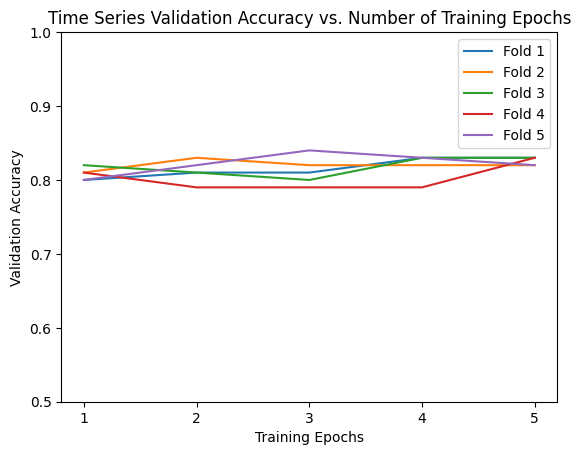

In [2]:
K1 = [0.80, 0.81, 0.81, 0.83, 0.83]
K2 = [0.81, 0.83, 0.82, 0.82, 0.82]
K3 = [0.82, 0.81, 0.80, 0.83, 0.83]
K4 = [0.81, 0.79, 0.79, 0.79, 0.83]
K5 = [0.80, 0.82, 0.84, 0.83, 0.82]
num_epochs = 5

plt.title("Time Series Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),K1,label="Fold 1")
plt.plot(range(1,num_epochs+1),K2,label="Fold 2")
plt.plot(range(1,num_epochs+1),K3,label="Fold 3")
plt.plot(range(1,num_epochs+1),K4,label="Fold 4")
plt.plot(range(1,num_epochs+1),K5,label="Fold 5")
plt.ylim((0.5,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
#Se definen las clases del dataset
classes = ('Under', 'Over', 'Empty', 'OK')

In [ ]:
# Create datasets for training and validation
image_datasets = {'train': train_data, 'val': val_data}

# Create dataloaders for training and validation
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
#En entas líneas de guardan los valores reales y supuestos del dataset y los resultados para las representaciones
y_pred_val = []
y_true_val = []
yscore_val = []

for inputs, labels in dataloaders_dict['val']: #validación o entrenamiento
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_val.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_val.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_val.extend(yscore)

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
yscore_val = np.array(yscore_val)

In [ ]:
y_pred_train = []
y_true_train = []
yscore_train = []

for inputs, labels in dataloaders_dict['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_train.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_train.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_train.extend(yscore)

y_pred_train = np.array(y_pred_train)
y_true_train = np.array(y_true_train)
yscore_train = np.array(yscore_train)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_true_train)
y_onehot_test = label_binarizer.transform(y_true_val)
y_onehot_test.shape  # (n_samples, n_classes)

(2000, 4)

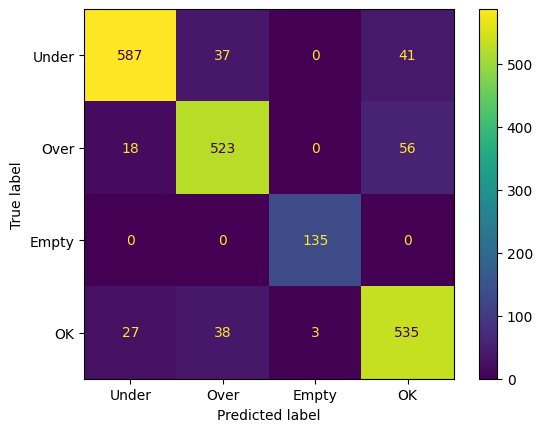

In [ ]:
# Mostrar matriz de confusion
cf_matrix = confusion_matrix(y_true_val, y_pred_val) #Validacion o entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()

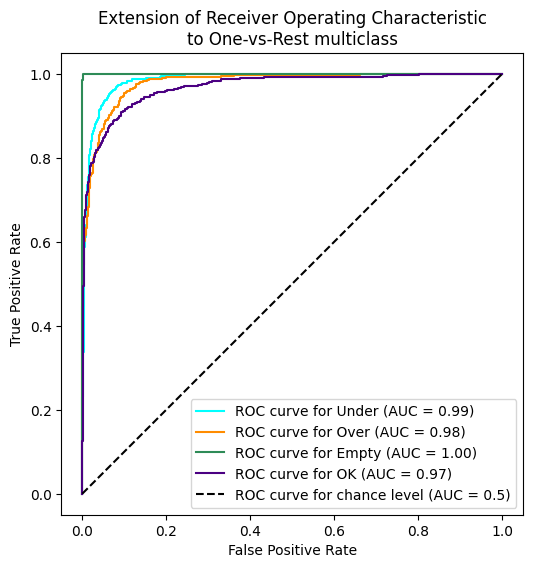

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

colors = cycle(["aqua", "darkorange", "seagreen","indigo"])
for class_id, color in zip(range(len(classes)), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        yscore_val[:, class_id],
        name=f"ROC curve for {classes[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [ ]:
class_dict = {0: 'Under', 1: 'Over', 2: 'Empty', 3: 'Ok'}
y_true_valnames = [(class_dict[label])
          for label in y_true_val
          if label in [0, 1, 2, 3]]

In [ ]:
from itertools import combinations


pair_list = list(combinations(np.unique(y_true_val), 2))
print(pair_list)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


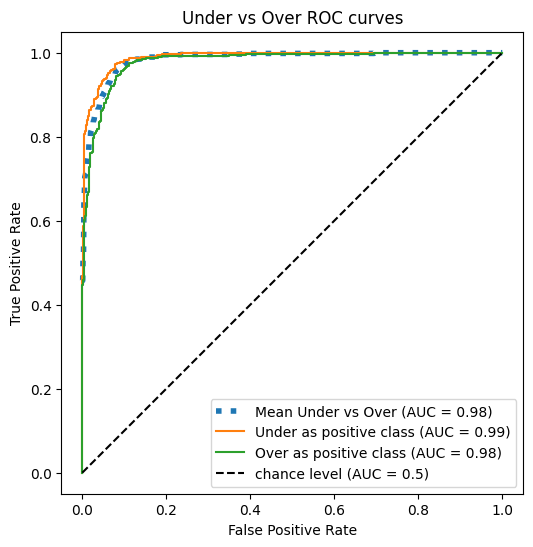

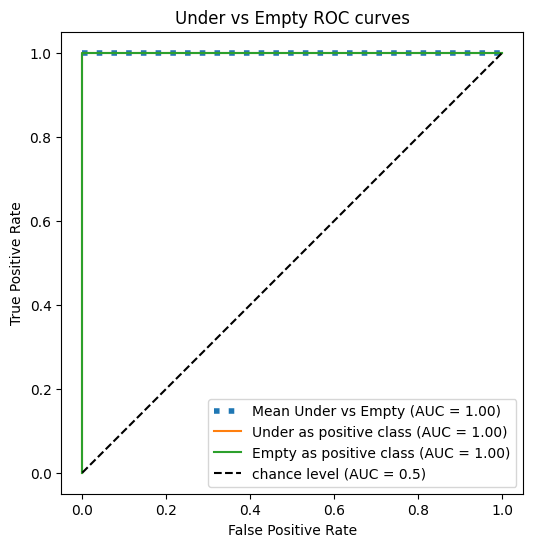

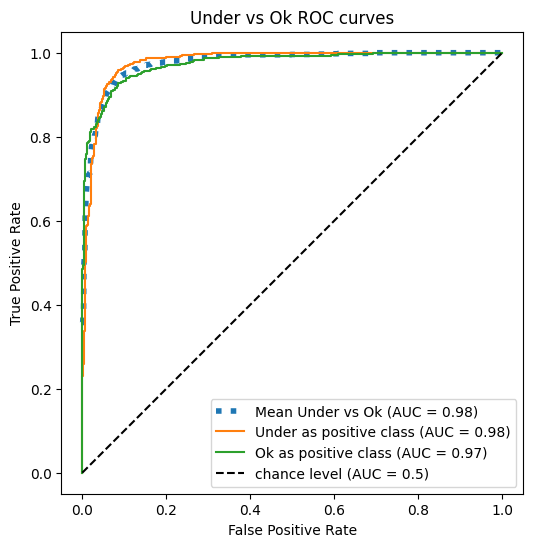

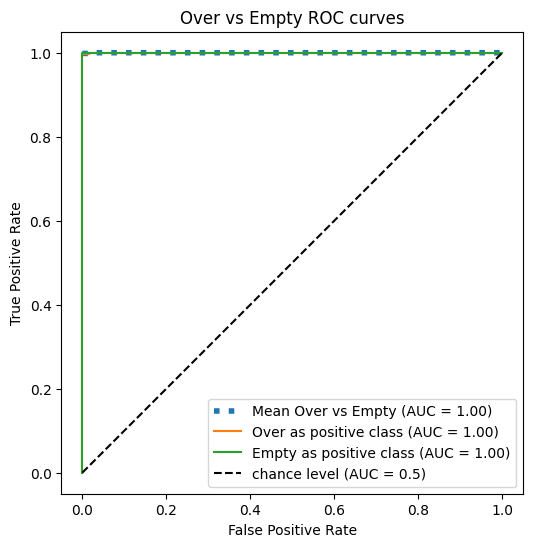

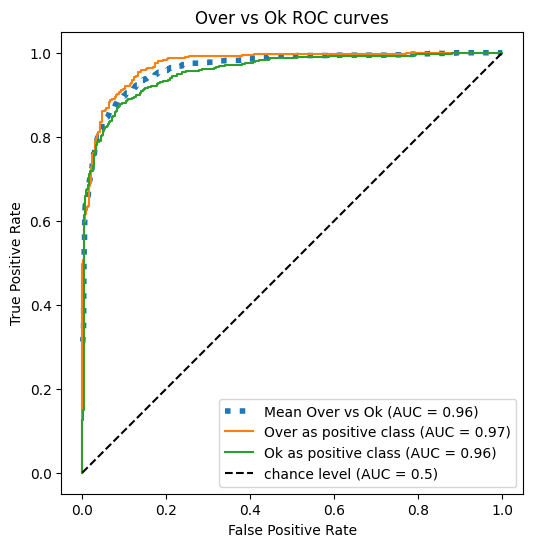

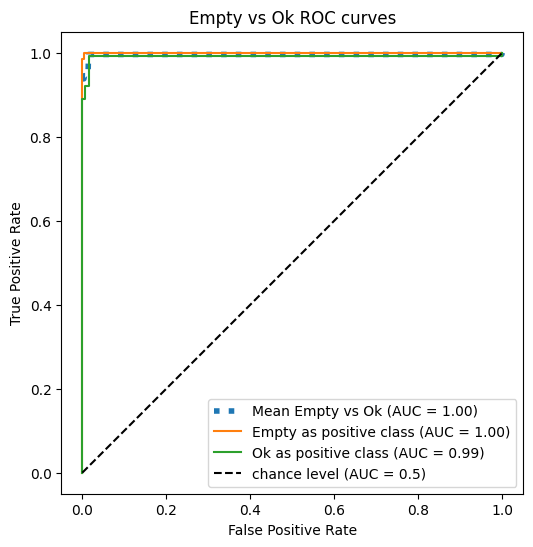

Macro-averaged One-vs-One ROC AUC score:
0.99


In [ ]:
from sklearn.metrics import roc_curve, auc

pair_scores = []
mean_tpr = dict()
fpr_grid = np.linspace(0.0, 1.0, 1000)

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_true_val == label_a
    b_mask = y_true_val == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, yscore_val[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, yscore_val[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {class_dict[label_a]} vs {class_dict[label_b]} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        yscore_val[ab_mask, idx_a],
        ax=ax,
        name=f"{class_dict[label_a]} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        yscore_val[ab_mask, idx_b],
        ax=ax,
        name=f"{class_dict[label_b]} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{classes[idx_a]} vs {class_dict[label_b]} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

# Imagenes mal clasificadas

In [ ]:
misclassified_images = [] #Se crea una variable para guardar las imagenes mal clasificadas

# Iterar sobre las imágenes del conjunto de validación
for images, labels in dataloaders_dict['val']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ft(images)
    _, predicted = torch.max(outputs, 1)
    incorrect_predictions = predicted != labels #Se crea una variable que indique si hay imagenes mal clasificadas
    misclassified_images.extend(zip(images[incorrect_predictions].cpu(), labels[incorrect_predictions].cpu(), predicted[incorrect_predictions].cpu())) #Se guardan

# Convertir las imágenes, etiquetas verdaderas y predicciones incorrectas en tensores
misclassified_images_tensors = [torch.stack(t) for t in zip(*misclassified_images)]

# Crear el TensorDataset a partir de los tensores
misclassified_images_dataset = torch.utils.data.TensorDataset(*misclassified_images_tensors)

In [ ]:
# Contar el número total de imágenes
num_images = len(misclassified_images)

# Imprimir el resultado
print(f"Número total de imágenes: {num_images}")

Número total de imágenes: 221


In [ ]:
# Crear un diccionario para almacenar las imágenes mal clasificadas de cada tipo
misclassified_dict = defaultdict(list)

# Recorrer todas las imágenes mal clasificadas y guardarlas en el diccionario
for image, true_label, predicted_label in misclassified_images_dataset:
    misclassified_dict[true_label.item()].append((image, true_label.item(), predicted_label.item()))

# Mostrar las imágenes mal clasificadas con sus etiquetas real y supuesta (No es necesario, comprobacion)
for true_label, misclassified_images in misclassified_dict.items():
    print(f"Imágenes mal clasificadas de tipo {true_label}:")
    for image, true_label, predicted_label in misclassified_images:
        print(f"Etiqueta real: {true_label}, Etiqueta supuesta: {predicted_label}")


Imágenes mal clasificadas de tipo 3:
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 2
Etiqueta real: 3, Etiqueta supuesta: 1
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta supuesta: 0
Etiqueta real: 3, Etiqueta 

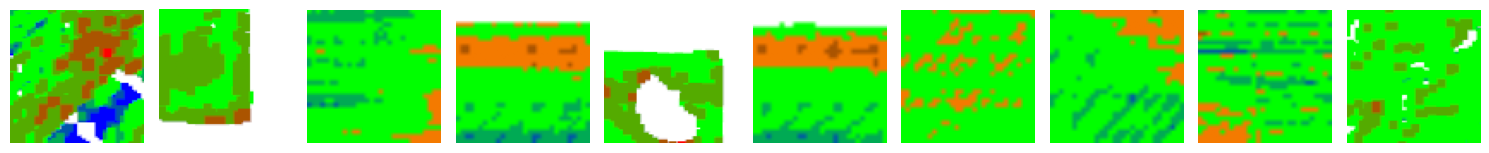

In [ ]:
# Definir la cantidad de imágenes que se mostrarán
num_images_to_show = 10

# Obtener las primeras 'num_images_to_show' imágenes
images_to_show = [image for image, _, _ in misclassified_images[:num_images_to_show]]

# Crear una cuadrícula para mostrar las imágenes
fig, axs = plt.subplots(1, num_images_to_show, figsize=(15, 3))

# Mostrar cada imagen en un subplot
for i, image in enumerate(images_to_show):
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].axis('off')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura con las imágenes
plt.show()


Imágenes mal clasificadas de tipo 3:


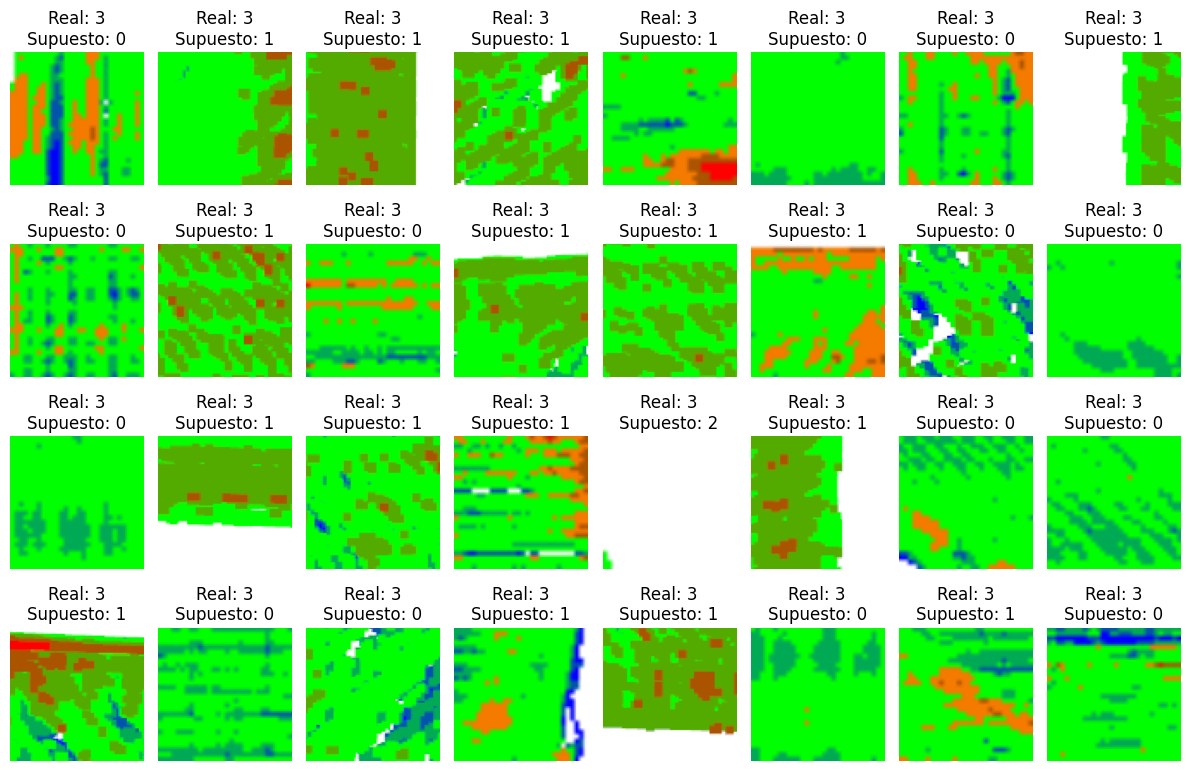

Imágenes mal clasificadas de tipo 1:


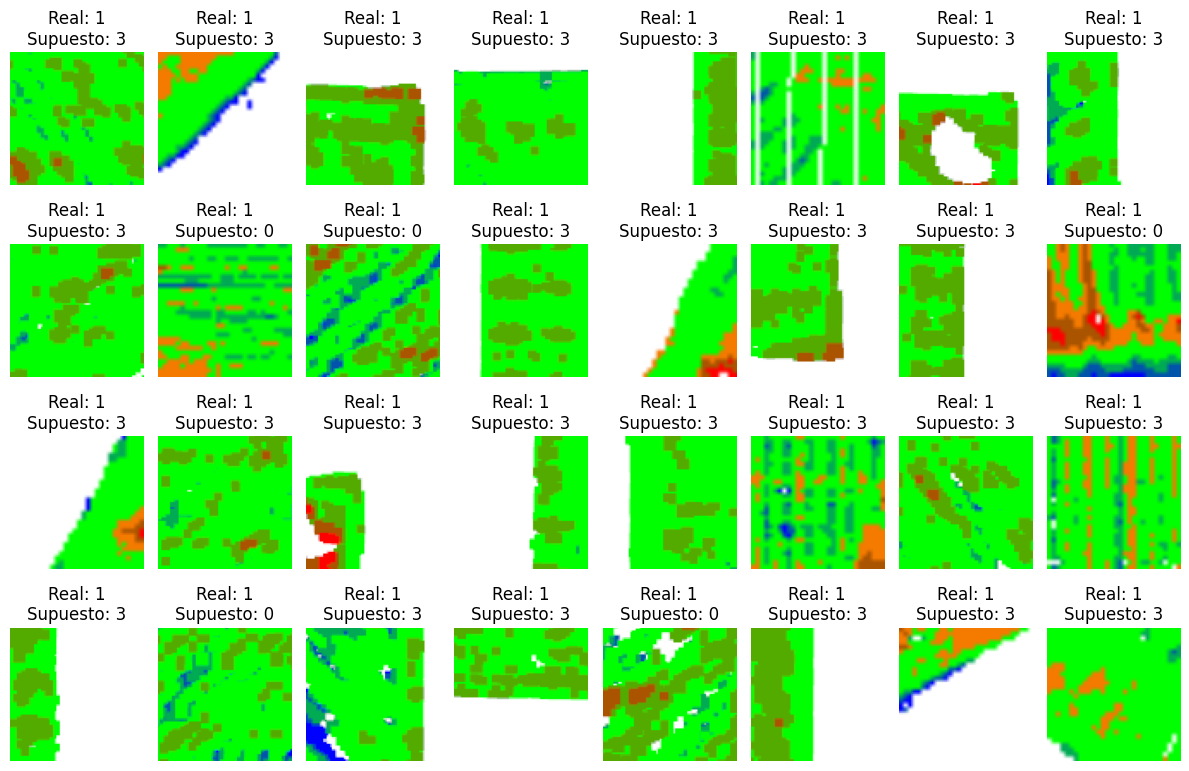

Imágenes mal clasificadas de tipo 0:


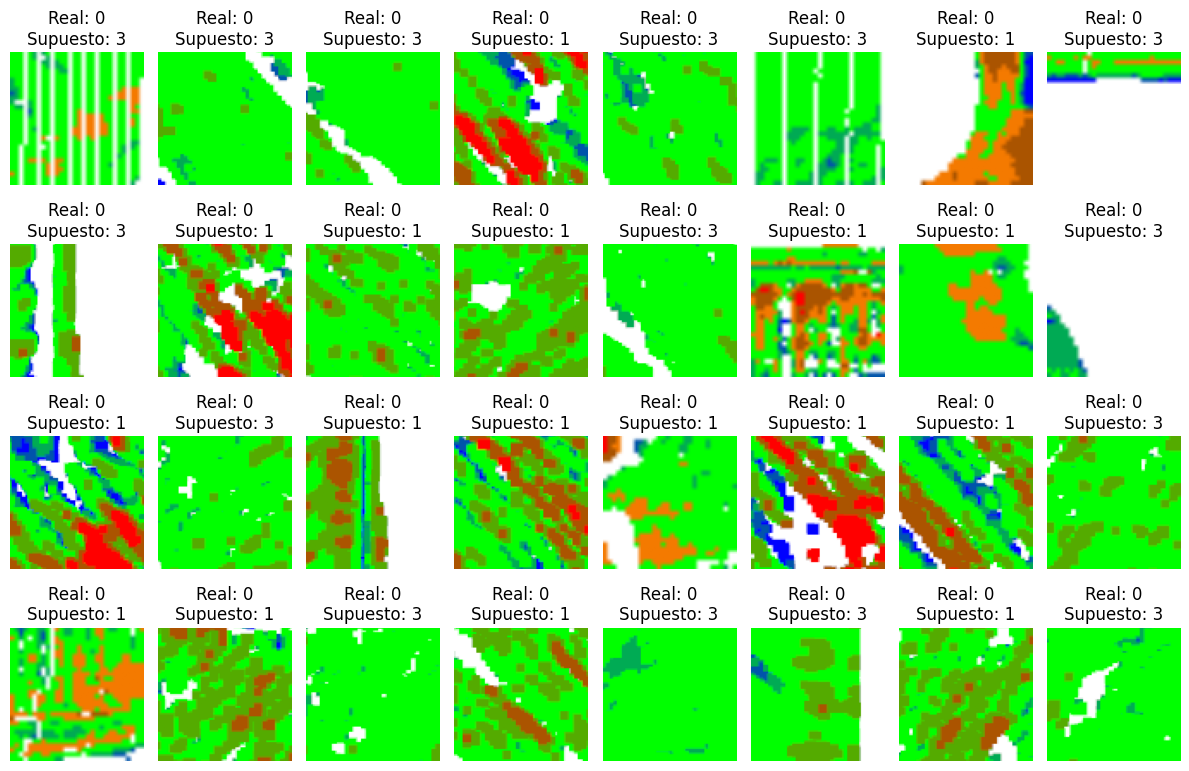

In [ ]:
# Recorrer las imágenes mal clasificadas y mostrarlas junto con su etiqueta real y supuesta
for true_label, misclassified_images in misclassified_dict.items():
    print(f"Imágenes mal clasificadas de tipo {true_label}:")
    
    # Crear una nueva figura para cada tipo de imagen
    fig = plt.figure(figsize=(12, 8))
    rows = 4
    cols = 8
    
    for i, (image, true_label, predicted_label) in enumerate(misclassified_images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.set_title(f"Real: {true_label}\nSupuesto: {predicted_label}")
        ax.imshow(image.permute(1, 2, 0))
        
        # Salir del bucle si se alcanza el número máximo de subplots por figura
        if i == (rows * cols - 1):
            break
    
    # Ajustar los espacios entre subplots
    plt.tight_layout()
    
    # Mostrar la figura actual
    plt.show()



  Imágenes mal clasificadas de tipo Ok:


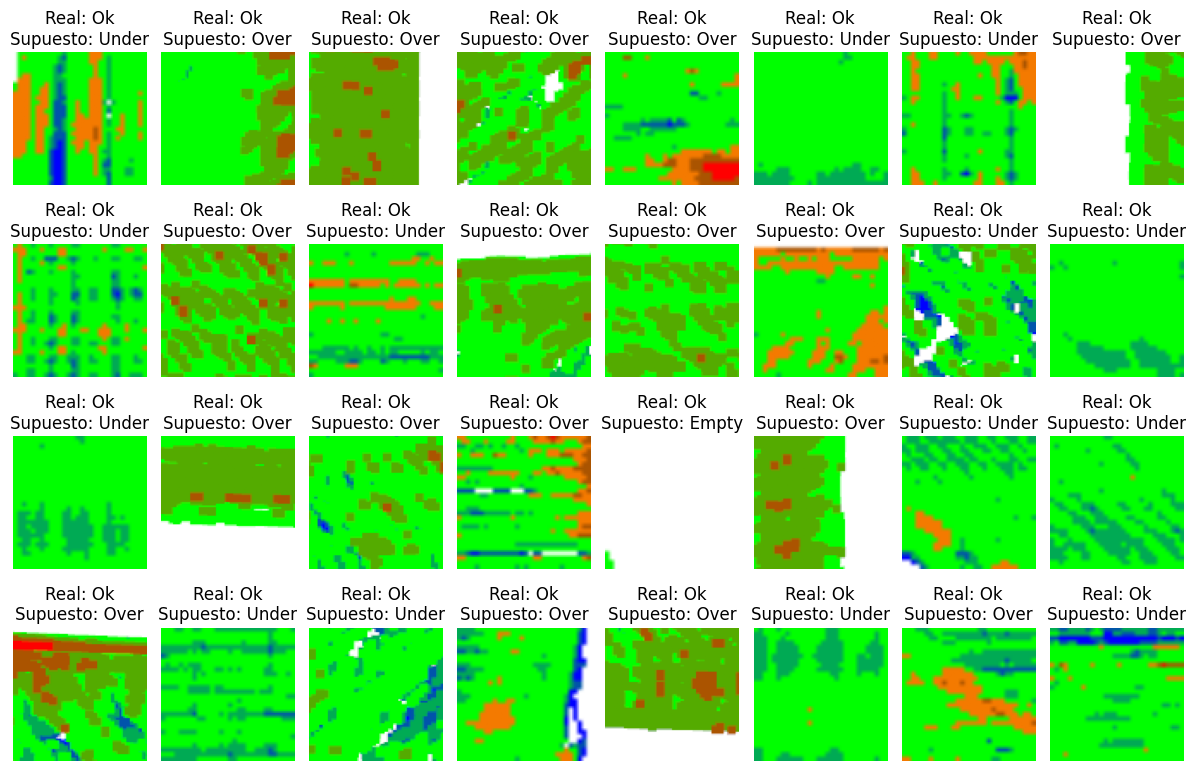


  Imágenes mal clasificadas de tipo Over:


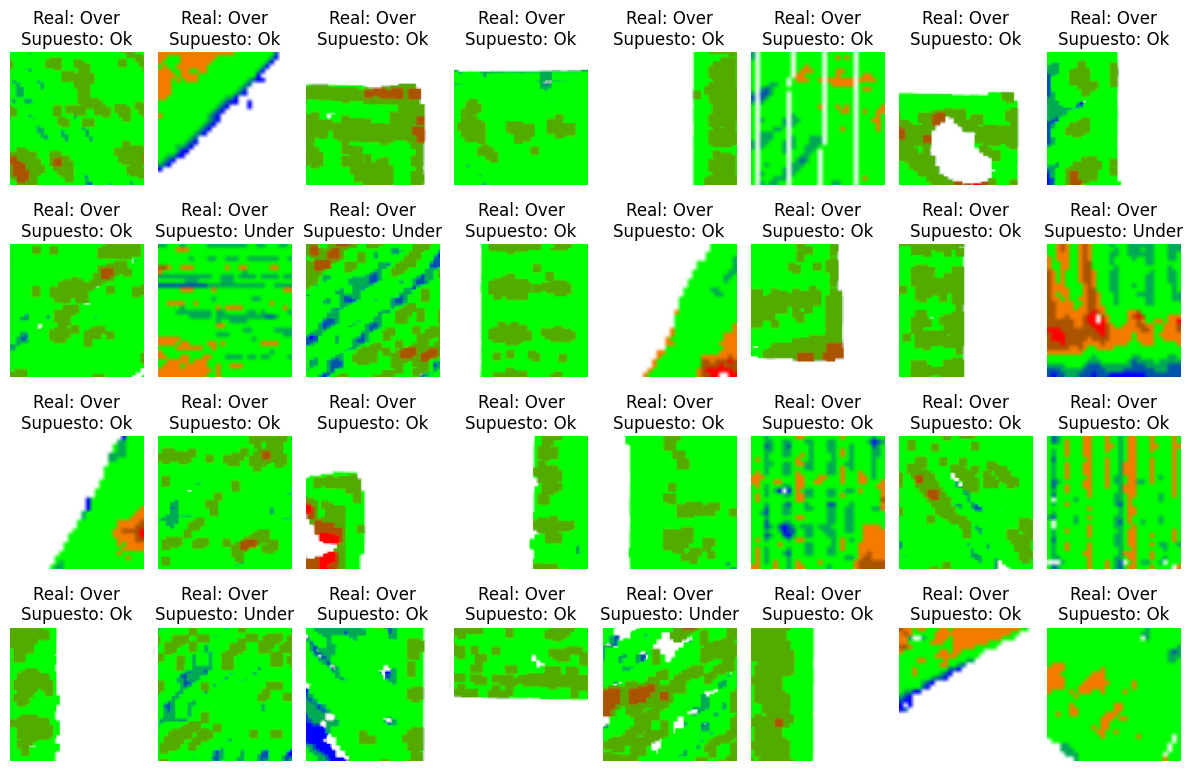


  Imágenes mal clasificadas de tipo Under:


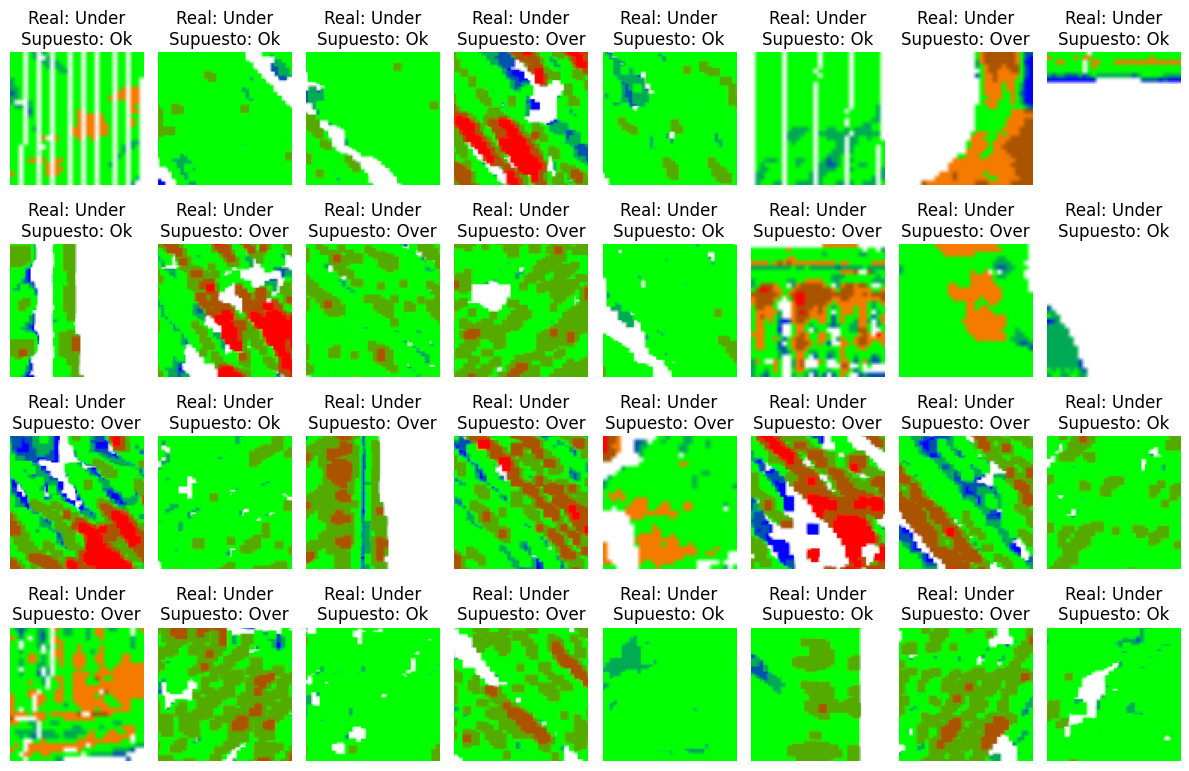

In [ ]:
import matplotlib.pyplot as plt

# Diccionario de mapeo de etiquetas numéricas a etiquetas deseadas
label_mapping = {
    0: "Under",
    1: "Over",
    2: "Empty",
    3: "Ok"
}

# Recorrer las imágenes mal clasificadas y mostrarlas en subplots más grandes
for true_label, misclassified_images in misclassified_dict.items():
    print(f"\n{'='*30}")
    print(f"  Imágenes mal clasificadas de tipo {label_mapping[true_label]}:")
    print(f"{'='*30}")
    
    # Crear una nueva figura para cada tipo de imagen
    fig = plt.figure(figsize=(12, 8))
    rows = 4
    cols = 8
    
    for i, (image, true_label, predicted_label) in enumerate(misclassified_images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.set_title(f"Real: {label_mapping[true_label]}\nSupuesto: {label_mapping[predicted_label]}", fontsize=12)  # Aumentar el tamaño del título
        ax.imshow(image.permute(1, 2, 0))
        
        # Salir del bucle si se alcanza el número máximo de subplots por figura
        if i == (rows * cols - 1):
            break
    
    # Ajustar los espacios entre subplots
    plt.tight_layout()
    
    # Mostrar la figura actual
    plt.show()
